## Load and Compile Data

**Importing required libraries and datasets**

In [375]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import os

DATA_PATH = '../data/vrd_data/'

We can inspect the datasets one at a time to ensure consistent setup. First we get all the datasets for convenience. Tournaments with same letter prefix tend to follow the same data setup.

In [385]:
filenames = []
for (dirpath, dirname, filename) in os.walk(DATA_PATH):
    filenames.extend(filename)
    break
print(*filenames)

cleaned_vrd_data.csv extras.csv VRD Archives - ALEX1.csv VRD Archives - CHI1.csv VRD Archives - CHI2.csv VRD Archives - CHI3.csv VRD Archives - DIS1.csv VRD Archives - DIS10.csv VRD Archives - DIS11.csv VRD Archives - DIS12.csv VRD Archives - DIS13.csv VRD Archives - DIS2.csv VRD Archives - DIS3.csv VRD Archives - DIS4.csv VRD Archives - DIS5.csv VRD Archives - DIS6.csv VRD Archives - DIS8.csv VRD Archives - DIS9.csv VRD Archives - GG1.csv VRD Archives - GG6.csv VRD Archives - MT1.csv VRD Archives - MT2.csv VRD Archives - MT3.csv VRD Archives - NWVRD2.csv VRD Archives - NWVRD3.csv VRD Archives - NWVRD4.csv VRD Archives - NWVRD5.csv VRD Archives - NWVRD6.csv VRD Archives - NWVRD7.csv VRD Archives - NWVRD8.csv VRD Archives - OCL3.csv VRD Archives - PDX1.csv VRD Archives - PDX2.csv VRD Archives - PDX3.csv VRD Archives - PDX4.csv VRD Archives - STL6.csv VRD Archives - StLotus1.csv VRD Archives - StLotus2.csv VRD Archives - StLotus3.csv VRD Archives - StLotus4.csv VRD Archives - StLotus5.cs

Example preview of a dataset.

In [394]:
df = pd.read_csv(DATA_PATH + 'VRD Archives - ALEX1.csv')
df.head()

,Unnamed: 0,JB,JW,AW,DL,JG,SW,MT,AP
0,Wins,2,2,6,5,3,5,1,4
1,Losses,5,5,1,2,4,2,6,3
2,Date,2014-12-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Notes,this came from some guy posting on a forum about his VRD: http://skullheart.com/index.php?threads/magic-the-gathering.6185/page-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Black Lotus,Mox Sapphire,Mox Jet,Mox Pearl,Ancestral Recall,Mox Ruby,Mox Emerald,LIBRARY OF ALEXANDRIA


**Define and populate dataframe colums.**

We will add more columns later.

In [378]:
df = pd.DataFrame(columns = ['card_name', 'pick_idx', 'player_idx', 'player_idx_rl', 'round_idx', 'deck_wins', 'deck_losses', 'player_id', 'tournament_id', 'date'])

Due to similar setup we can loop through all of the libraries in order.

In [395]:
for file in os.listdir(DATA_PATH):
    if file.startswith('VRD Archives - '):
        
        # 12 players in this data which would skew the results
        if file == 'VRD Archives - CHI1.csv': continue
        # Uncooperative, will skip for now
        elif file == 'VRD Archives - GG6.csv': continue
        elif file == 'VRD Archives - TAN1.csv': continue
        #print(file)
        
        # Get tournament id
        tournament_id = file.split(' - ')[1].replace('.csv', '')
        
        tmp_df = pd.read_csv(DATA_PATH + file)
        
        # Get date
        date = tmp_df[tmp_df.iloc[:, 0].str.contains('Date', na=False, case=False)].iloc[:, 1].iloc[-1]                
        
        # Get player ids in an ordered list
        player_ids = list(tmp_df)[1:]
        
        # Get player wins in an ordered list
        wins = tmp_df[tmp_df.iloc[:, 0].str.contains('Wins', na=False, case=False)].iloc[:, 1:].values[0] #unpack double list

        # Get player losses in an ordered list
        losses = tmp_df[tmp_df.iloc[:, 0].str.contains('Losses', na=False, case=False)].iloc[:, 1:].values[0] #unpack double list
        
        # Now we grab the card names and relative indexes. The cards are picked in order from left to right in the first row, 
        # and then every other row, and from the right to left otherwise, following a back and forth pattern.
        # This can be added to the dataframe including the previously obtained data.
        
        # find index of the row with 1 in the first cell, that's where card selection begins
        start_row = tmp_df[tmp_df.iloc[:, 0]=='1'].index.values.astype(int)[0]
        
        # get a slice containing the drafted cards
        cards_df = tmp_df.iloc[start_row:,1:9].reset_index(drop=True)
        cards_df.index += 1 # make index equal to round
        cards_df = cards_df.applymap(lambda s: s.lower().strip() if type(s) == str else s)
        
        # Maps to map player_ids to wins, losses, and player_idx
        map_idx = {player_ids[i]: player_ids.index(player_ids[i])+1 for i in range(len(player_ids))}
        map_idx_rl = {player_ids[i]: [8, 7, 6, 5, 4, 3, 2, 1][i] for i in range(len(player_ids))}
        map_wins = {player_ids[i]: wins[i] for i in range(len(player_ids))}
        map_losses = {player_ids[i]: losses[i] for i in range(len(player_ids))}
        
        # Compile pandas DataFrame per dataset
        dfs = cards_df.stack().reset_index() #stack cards according to tournament pick order
        dfs['pick_idx'] = dfs.index + 1 #make pick numbering start from 1
        
        # Misc cleanup
        dfs.rename(columns = {'level_0': 'round_idx', 0: 'card_name', 'level_1': 'player_id'}, inplace = True)
        dfs['tournament_id'] = tournament_id
        dfs['date'] = date
        
        # Mappings
        dfs['player_idx'] = dfs['player_id'].map(map_idx)
        dfs['player_idx_rl'] = dfs['player_id'].map(map_idx_rl)
        dfs['deck_wins'] = dfs['player_id'].map(map_wins)
        dfs['deck_losses'] = dfs['player_id'].map(map_losses)
        
        # Adjust pick order for even rounds (since it goes in the opposite direction)
        dfs.loc[dfs['round_idx']%2 == 0, 'pick_idx'] = (dfs['round_idx']-1)*8+dfs['player_idx_rl']
        
        # Select and organize columns
        dfs = dfs[['card_name', 'pick_idx', 'player_idx', 'player_idx_rl', 'round_idx', 'deck_wins', 'deck_losses', 'player_id', 'tournament_id', 'date']]
        
        # Stack the DataFrames on top of each other
        df = pd.concat([df, dfs.reset_index(drop=True)], axis=0)
        

Check if everything looks alright so far.

In [396]:
pd.set_option("display.max_rows", 60, "display.max_columns", None)
dfs

,card_name,pick_idx,player_idx,player_idx_rl,round_idx,deck_wins,deck_losses,player_id,tournament_id,date
0,black lotus,1,1,8,1,1,3,April,YYZ1,2020-04-11
1,ancestral recall,2,2,7,1,3,3,David,YYZ1,2020-04-11
2,sol ring,3,3,6,1,5,0,Dom Reborn,YYZ1,2020-04-11
3,time vault,4,4,5,1,1,2,Alex,YYZ1,2020-04-11
4,mox sapphire,5,5,4,1,0,3,Jacob,YYZ1,2020-04-11
...,...,...,...,...,...,...,...,...,...,...
355,future sight,356,4,5,45,1,2,Alex,YYZ1,2020-04-11
356,"ulamog, the ceaseless hunger",357,5,4,45,0,3,Jacob,YYZ1,2020-04-11
357,secluded steppe,358,6,3,45,2,3,Andrew,YYZ1,2020-04-11
358,seedtime,359,7,2,45,2,4,Freyja,YYZ1,2020-04-11


**Save progress**

In [336]:
df.to_csv(DATA_PATH + '/cleaned_vrd_data.csv', index=False)

# To do
Data Cleaning:
- Update wins based on the extra data source

EDA:
- pick priority first n rounds
- cards with highest winrate

More later:
- identify card colours from api
- Include card types and subtypes
- best performing colour combinations
- best cards per colour (based on winrate)
- best cards per colour (based on absolute pick order)
- When are lands picked?
- Lands priority order
- Total mana curve

In [370]:
df['tournament_id'].unique()

array(['ALEX1', 'CHI2', 'CHI3', 'DIS1', 'DIS10', 'DIS11', 'DIS12',
       'DIS13', 'DIS2', 'DIS3', 'DIS4', 'DIS8', 'DIS9', 'GG1', 'MT1',
       'MT2', 'MT3', 'NWVRD2', 'NWVRD3', 'NWVRD4', 'NWVRD5', 'NWVRD6',
       'NWVRD7', 'NWVRD8', 'OCL3', 'PDX1', 'PDX2', 'PDX3', 'PDX4',
       'StLotus1', 'StLotus2', 'StLotus3', 'StLotus4', 'StLotus5',
       'StLotus7', 'StLotus8', 'STLPresents1', 'TAN2', 'VIC8', 'WIN1',
       'WIN2', 'WIN3', 'WIN4', 'WIN7', 'YYZ1'], dtype=object)

<AxesSubplot:>

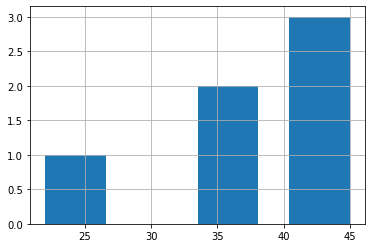

In [398]:
df.loc[df['card_name']=='seedtime']['round_idx'].hist()